## Dependencies

In [1]:
!pip3 show torch

Name: torch
Version: 1.7.0+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, typing-extensions, future, dataclasses
Required-by: torchvision, torchtext, fastai


In [2]:
# !git clone https://github.com/bfortuner/pytorch_tiramisu/
!git clone https://github.com/HarshitDaftary/ImageSegmentation

Cloning into 'ImageSegmentation'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 53 (delta 8), reused 43 (delta 2), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [3]:
# !mv /content/pytorch_tiramisu/* /content/
!mv ImageSegmentation/* .

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import tiramisu
from datasets import camvid
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CamVid

Clone this repository which holds the CamVid dataset
```
git clone https://github.com/alexgkendall/SegNet-Tutorial
```

In [4]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 44.78 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [5]:
!wget <dataset_url>
!rm -rf SegNet-Tutorial/CamVid/*
!mv dataset.zip SegNet-Tutorial/CamVid/
!unzip SegNet-Tutorial/CamVid/dataset.zip -d SegNet-Tutorial/CamVid/
!rm -rf SegNet-Tutorial/CamVid/__MACOSX
!rm -rf SegNet-Tutorial/CamVid/dataset.zip

--2020-11-29 15:08:41--  https://im-upscane.s3.us-east-2.amazonaws.com/dataset.zip
Resolving im-upscane.s3.us-east-2.amazonaws.com (im-upscane.s3.us-east-2.amazonaws.com)... 52.219.100.56
Connecting to im-upscane.s3.us-east-2.amazonaws.com (im-upscane.s3.us-east-2.amazonaws.com)|52.219.100.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574986276 (548M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 548.35M  50.3MB/s    in 11s     

2020-11-29 15:08:53 (48.3 MB/s) - ‘dataset.zip’ saved [574986276/574986276]

Archive:  SegNet-Tutorial/CamVid/dataset.zip
  inflating: SegNet-Tutorial/CamVid/test.txt  
  inflating: SegNet-Tutorial/CamVid/train.txt  
  inflating: SegNet-Tutorial/CamVid/val.txt  
   creating: SegNet-Tutorial/CamVid/test/
  inflating: SegNet-Tutorial/CamVid/test/human_235.png  
  inflating: SegNet-Tutorial/CamVid/test/human_86.png  
  inflating: SegNet-Tutorial/CamVid/test/human_45.png  
  inflating: Seg

In [6]:
!mv ImageSegmentation/* .

In [7]:
CAMVID_PATH = Path('', 'SegNet-Tutorial/CamVid')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 2

In [11]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)
train_joint_transformer = transforms.Compose([
    # joint_transforms.JointRandomCrop(224), # commented for fine-tuning
    joint_transforms.JointScale(300),
    joint_transforms.JointCenterCrop(300),
    # joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=train_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=train_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 300
Val: 104
Test: 100
Classes: 2
Inputs:  torch.Size([2, 3, 300, 300])
Targets:  torch.Size([2, 300, 300])


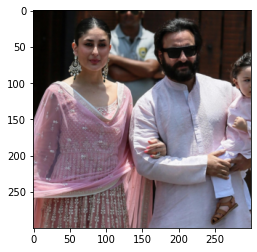

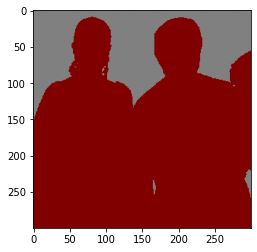

In [12]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
utils.imgs.view_annotated(targets[0])

## Train

In [13]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 2
torch.cuda.manual_seed(0)

In [14]:
model = tiramisu.FCDenseNet67(n_classes=2).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
#criterion = nn.NLLLoss(weight=camvid.class_weight.cuda()).cuda()
criterion = nn.NLLLoss().cuda()

In [15]:
N_EPOCHS = 100

In [16]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()
    dict_read = {"epoch":"{:d}".format(epoch)}
    ### Train ###
    trn_loss, trn_err = train_utils.train(model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    ### Test ###
    val_loss, val_err = train_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    


    ### Checkpoint ###    
    train_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 0.6815, Acc: 1.0000
Train Time 1m 16s
Val - Loss: 0.7018 | Acc: 1.0000
Total Time 1m 27s

Epoch 2
Train - Loss: 0.5253, Acc: 1.0000
Train Time 1m 19s
Val - Loss: 0.8665 | Acc: 1.0000
Total Time 1m 30s

Epoch 3
Train - Loss: 0.5173, Acc: 1.0000
Train Time 1m 20s
Val - Loss: 0.9272 | Acc: 1.0000
Total Time 1m 31s

Epoch 4
Train - Loss: 0.5005, Acc: 1.0000
Train Time 1m 20s
Val - Loss: 0.8059 | Acc: 1.0000
Total Time 1m 31s

Epoch 5
Train - Loss: 0.4726, Acc: 1.0000
Train Time 1m 20s
Val - Loss: 0.7377 | Acc: 1.0000
Total Time 1m 31s

Epoch 6
Train - Loss: 0.4660, Acc: 1.0000
Train Time 1m 20s
Val - Loss: 0.9388 | Acc: 1.0000
Total Time 1m 31s

Epoch 7
Train - Loss: 0.4650, Acc: 1.0000
Train Time 1m 20s
Val - Loss: 0.8080 | Acc: 1.0000
Total Time 1m 31s

Epoch 8
Train - Loss: 0.4354, Acc: 1.0000
Train Time 1m 20s
Val - Loss: 1.0256 | Acc: 1.0000
Total Time 1m 31s

Epoch 9
Train - Loss: 0.4433, Acc: 1.0000
Train Time 1m 20s
Val - Loss: 0.6410 | Acc: 1.0000
Total Time 

## Test

In [17]:
train_utils.test(model, test_loader, criterion, epoch=1)  

(tensor(0.2889, device='cuda:0'), tensor(0., dtype=torch.float64))

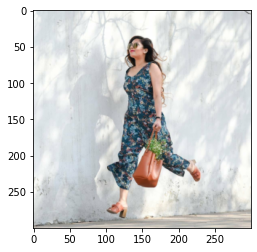

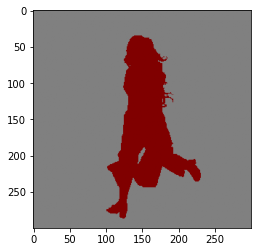

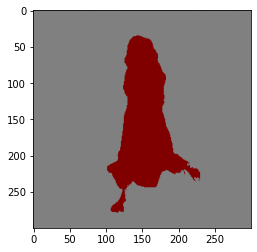

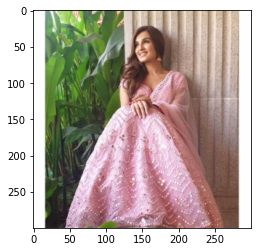

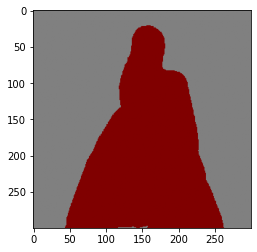

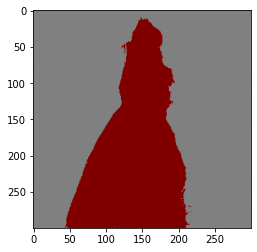

In [23]:
train_utils.view_sample_predictions(model, test_loader, n=10)

In [19]:
!mv .weights weights
!mv .results results

#Load Pretrained Model for Testing

In [20]:
torch.cuda.empty_cache()
import os
weights_fname = 'weights-%d-%.3f-%.3f.pth' % (11, 0.690, 0.000)
weights_fpath = os.path.join(WEIGHTS_PATH, weights_fname)

# path = ".weights/weights-11-0.690-0.000.pth"

# model = model.cpu()
# criterion =  criterion.cpu()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

train_utils.load_weights(model,weights_fpath)